In [47]:
import os
import numpy as np
from ml_eps_v_predictor import *
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from gsm_ve import GSM_VE

In [48]:
# Define data directory

data_root_dir = Path(os.path.expanduser("~")) / "bmcs_training_data"
dataset = ViscoelasticDataset(data_root_dir, normalize=True)



Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.1A\Pi_data_10C_0.1A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.2A\Pi_data_10C_0.2A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.3A\Pi_data_10C_0.3A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.4A\Pi_data_10C_0.4A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.5A\Pi_data_10C_0.5A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.6A\Pi_data_10C_0.6A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.7A\Pi_data_10C_0.7A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.8A\Pi_data_10C_0.8A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.9A\Pi_data_10C_0.9A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_1.0A\Pi_data_10C_1.0A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_1.1A\Pi_data_10C_1.1A.npy
Loading data from: C:\Users\adel

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Create GSM_VE instance
pi_gsm_ve = GSM_VE()

# Material parameters
E_val = 30e+3  # Young's modulus in MPa
eta_val = 30e+6  # Viscosity modulus in Pa / s
mparams = (E_val, eta_val)

# Time step and final time
d_t_val = 0.01  # Time step in seconds
final_time = 40  # Final time in seconds  # 

# Define specific amplitude and cycle
cycle = 2  # Choose a specific cycle
amp = 1.0  # Choose a specific amplitude (in %)

case_name = f"{cycle}C_{amp}A_{final_time}S"  # Unique name

# Generate time vector
time_t = np.linspace(0, final_time, int(final_time / d_t_val) + 1)

# Generate sinusoidal strain history
eps_t = (amp / 100) * np.sin(np.pi * cycle * time_t / final_time)

pi_gsm_ve.problem_name = case_name  # Save data with unique name

# Perform integration (assuming pi_gsm_ve.perform_integration exists)
gsm_ve_data = pi_gsm_ve.perform_integration(eps_t, time_t, *mparams)

print(f"Processed case: {case_name}")
save_path = pi_gsm_ve.data_dir / f'{case_name}.png'

# Create a figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

# Plot results using the GSM_VE method
pi_gsm_ve.plot_results(ax1, ax2, ax3, gsm_ve_data, case_name, 'blue')

# Adjust layout
fig.tight_layout()

# Save the figure
fig.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Figure saved at: {save_path}")
plt.close(fig)


Processed case: 2C_1.0A_40S
Figure saved at: C:\Users\adelpasand\bmcs_training_data\2C_1.0A_40S\2C_1.0A_40S.png


In [50]:
# Load the .npy file
sample_data_1 = np.load(data_root_dir / '2C_1.0A' / 'Pi_data_2C_1.0A.npy')
# sample_data_1 = np.load(data_root_dir / '2C_1.0A_40S' / 'Pi_data_2C_1.0A_40S.npy')

In [51]:
# Extract input and target values
eps_t = sample_data_1[:-1, 0]  # Current step strain
dd_eps_t = sample_data_1[:-1, 1]  # Current step strain rate
eps_v_t = sample_data_1[:-1, 2]  # Current step viscoelastic strain
d_t = sample_data_1[:-1, 3]  # Current step time or damage variable

# Target: next step viscoelastic strain
eps_v_next = sample_data_1[1:, 2]

# Prepare input tensor
input_tensor = np.column_stack((eps_t, dd_eps_t, eps_v_t, d_t))

# Normalize inputs
mean = dataset.mean
std = dataset.std
input_normalized = (input_tensor - mean) / (std + 1e-8)  # Avoid division by zero
input_tensor = torch.tensor(input_normalized, dtype=torch.float32)


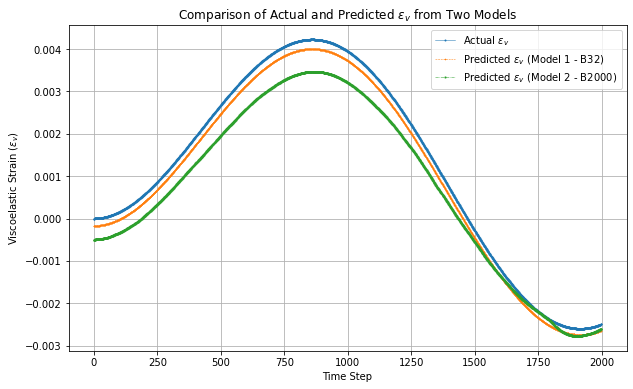

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load first model
model_1 = VE_TimeIntegrationPredictor().to(device)
model_1.load_state_dict(torch.load("ve_ivp_e100_b32.pth", map_location=device))
model_1.eval()

# Load second model
model_2 = VE_TimeIntegrationPredictor().to(device)
model_2.load_state_dict(torch.load("ve_ivp_e100_b2000.pth", map_location=device))
model_2.eval()

# Move input to device
input_tensor = input_tensor.to(device)

# Make predictions using both models
with torch.no_grad():
    predictions_1 = model_1(input_tensor).cpu().numpy().flatten()
    predictions_2 = model_2(input_tensor).cpu().numpy().flatten()

# Plot actual vs. predicted viscoelastic strain
plt.figure(figsize=(10, 6))
plt.plot(eps_v_next, label='Actual $\epsilon_v$', linestyle='-', marker='o', markersize=1, linewidth=0.5)
plt.plot(predictions_1, label='Predicted $\epsilon_v$ (Model 1 - B32)', linestyle='--', marker='x', markersize=1, linewidth=0.5)
plt.plot(predictions_2, label='Predicted $\epsilon_v$ (Model 2 - B2000)', linestyle='-.', marker='s', markersize=1, linewidth=0.5)


plt.xlabel("Time Step")
plt.ylabel("Viscoelastic Strain ($\epsilon_v$)")
plt.legend()
plt.title("Comparison of Actual and Predicted $\epsilon_v$ from Two Models")
plt.grid()
plt.show()


MSE: 0.000000
RMSE: 0.000184
MAE: 0.000184
R^2: 0.993327
Pearson Correlation: 0.999999


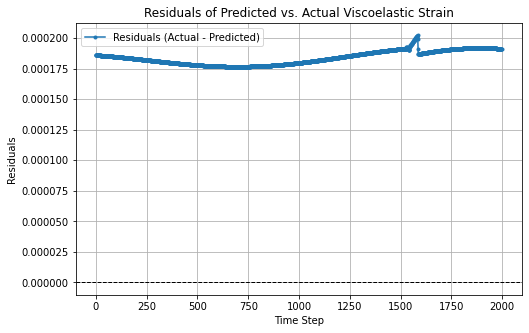

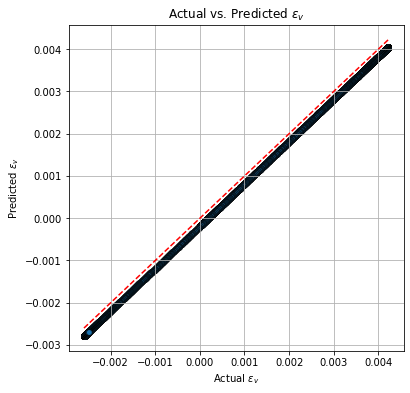

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute Mean Squared Error (MSE)
mse = np.mean((eps_v_next - predictions_1) ** 2)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(eps_v_next - predictions_1))

# Compute R-squared (R²)
ss_total = np.sum((eps_v_next - np.mean(eps_v_next)) ** 2)
ss_residual = np.sum((eps_v_next - predictions_1) ** 2)
r2 = 1 - (ss_residual / ss_total)

# Compute Pearson Correlation Coefficient (r)
pearson_corr, _ = pearsonr(eps_v_next, predictions_1)

# Print the metrics
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'R^2: {r2:.6f}')
print(f'Pearson Correlation: {pearson_corr:.6f}')

# Residual Plot
plt.figure(figsize=(8, 5))
residuals = eps_v_next - predictions_1
plt.plot(residuals, label='Residuals (Actual - Predicted)', linestyle='-', marker='o', markersize=3)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero error line
plt.xlabel("Time Step")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals of Predicted vs. Actual Viscoelastic Strain")
plt.grid()
plt.show()

# Scatter Plot for Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(eps_v_next, predictions_1, alpha=0.7, edgecolors='k')
plt.plot([min(eps_v_next), max(eps_v_next)], [min(eps_v_next), max(eps_v_next)], 'r--')  # Perfect fit line
plt.xlabel("Actual $\epsilon_v$")
plt.ylabel("Predicted $\epsilon_v$")
plt.title("Actual vs. Predicted $\epsilon_v$")
plt.grid()
plt.show()
